# Intro to HPC: Solar Cell project

Project: Solar Power for Affordable Housing through Computational Design of Low-Cost/High-Efficiency Solar Cells.
Author: AlvaroVM [https://alvarovm.github.io](http://alvarovm.github.io)

Version: 0.0.2

## Part 1: Cleaning and cannonizing DB

The goal of this notebook is to clean  the file that containt the DyeDB generated from dumping a database of results from calculations and data minig literature. Given the complexity of the calculations, some of the cells are empty.

Using a Pandas `Dataframe` we will open the data set replace missing values with zeros, and add descriptors and fingerprints that would be useful to create molecular maps and apply machine learning.

**NOTE** It is important to complete this notebook in order to create a file with the data needed for the next activities (visualization, analysis and machine learning).



### 1.1 Loading up packages and setting up variables

The following lines will load the minimum packages needed to complete this excersice.


All this packages were installed using the following script:
``` bash
conda env create -f environment2025.yml           #create environment within conda
conda activate solarcelldata                      #activate environment
python -m ipykernel -install -user -n solarcell   #add envinroment to a jupyter kernel
```

In this project will use `solarcelldata` kernel all ready installed on NERSC computers.



In [1]:
%matplotlib inline

import sys
import os
SRC_DIR='..'


import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
#https://github.com/jmcarpenter2/swifter
#import swifter
#2-TSNE-UMAP-map-cuda-Copy1

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs 
from rdkit.Chem import Draw
from rdkit.Chem.rdMolDescriptors import  GetHashedMorganFingerprint
from rdkit.DataStructs import ConvertToNumpyArray


## ADDING project code
sys.path.append(os.path.join(SRC_DIR, 'code'))
import utils #Helper functions. File located on code/utils.py

utils.plot_settings2() #Setting up ploting variables


results_path = os.path.join(SRC_DIR,'results')

../code/utils.py:3: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


### 1.2 Tools to Cannonize SMILES :))

In computational chemisty we can represent molecules using SMILES strings, which stands for **Simplified Molecular Input Line Entry System** [See ::wiki::](https://en.wikipedia.org/wiki/Simplified_Molecular_Input_Line_Entry_System). SMILES represent molecules in 2D, the elements, the order and special characters ( for example: `()`, `.`,`=`) indicate how the atoms are connected to form molecules. This representation missed the distances of the atoms or the angles, nevertheless, SMILES are useful to get the formula and identify chemical compounds. SMILES very useful and are widely adopted in many braches of computational chemisty, such as cheminformatics comunity. 

A problem of using SMILES is that the can be corrupted (invalid) easily, also there is not a single way to describe a molecule using SMILES, this more than one SMILES could produce the same molecule.


In [2]:
from rdkit.Chem import MolFromSmiles as smi2mol


import re

def canon_smiles(smi):
    """
    Function to cannonize a SMILE string accordingly with RDKIT package, thus the representation will be unique
    Return type: Characters
    """
    try:
        m = smi2mol(smi)
        sim = Chem.MolToSmiles(m, isomericSmiles=True, canonical=True)
    except:
        print(f'We cannot cannonize {smi}')
        smi = 'nan'
        
    return smi
    

def CleanSMI(smi):
    """
    Function to clean a SMILE string and reget rid of non standard characters 
    Return type: Characters
    """
    try: 
        clean=re.sub(r'[<>%\\/?\|]+', '', smi)
    except:
        print(f'We cannot clean {smi}')
        clean =False
    return clean

def HardValidSMI(smi):
    """
    A rule based function to validate a given SMILES string. Validad molecules are neutral molecules without metals or hyperconjugated bonds.
    Return type: Boolean
    True: If a match is found. 
    False: Charges, Ions and No Conjugated regions found.
    """

    mysmile = CleanSMI(smi)

    if mysmile != 'nan':
        try: 
            illegalstring = re.search(r'\\|/|\*|Fe|\+\+|\.|\|',mysmile) #--> Sanity check!
        except:
            print(f'Invalid SMILE {smi}')
            illegalstring = True
    else:
        return False
    
    if illegalstring:
        return False
    else:
        cansmile = canon_smiles(mysmile)
        if cansmile is False:
            return False
        match = re.search(r'\[\w{1,3}[\+-\.\d]+\]|\[\w{2}\]|\.|\(\*\)',cansmile)
        if match:
            return False
        else:
            conjuated = re.search(r'[a-z\W]\d+[a-zD-Z\W]+\d',mysmile) #r'[a-z\W]\d+[\w\W]+\d' or use (r'[a-z\W]\d+[a-zD-Z\W]+\d',mysmile) )
            if conjuated:
                return True
            else:
                return False

Testing `canon_smiles` function:

In [3]:
smi = 'Clc1ccc(c(c1)Cl)OCCn1cncc1'
print(f'The canonical form of {smi} -> {canon_smiles(smi)}')

The canonical form of Clc1ccc(c(c1)Cl)OCCn1cncc1 -> Clc1ccc(c(c1)Cl)OCCn1cncc1


Unfortunately some of the SMILE that define the molecules are not valid. We have a function called `HardValidSMI` which validate whether the SMILES can be processed. See example

In [4]:
#smi=df['smi_post'].iloc[0]
smi = 'O=C1O[C@H]([C@@H](O)CO)C(O)=C1O'
print(f'Q: Is this {smi} a valid molecule? A: {HardValidSMI(smi)}')

Q: Is this O=C1O[C@H]([C@@H](O)CO)C(O)=C1O a valid molecule? A: False


### 1.3 Vector fingerprint of a molecule

In order to teach a computer chemistry, we need to convert molecules with an numerical object (matrix, vector, etc) that can be processed by machine learning algorithms. In this project we will convert SMILES strings in a vector unsing **Circular Morgan fingerprints** ([learn more](https://schwallergroup.github.io/practical-programming-in-chemistry/tutorials/lecture_05/03_rdkit_fingerprints.html)).  The fingerprint vectors could be binary (`0/1`) or scalar (`{1,2,..}`).

![Morgan FP](https://blog.dnanexus.com/hs-fs/hubfs/Imported_Blog_Media/Morgan-Algorithm-1024x653.png?width=512&height=323&name=Morgan-Algorithm-1024x653.png)

The following routines will help us to compute Morgan fingerprints from a given SMILES string:

In [5]:
from rdkit.Chem.rdMolDescriptors import  GetHashedMorganFingerprint,GetMorganFingerprintAsBitVect
from rdkit.DataStructs import ConvertToNumpyArray

from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator

# Create a Morgan fingerprint generator


def applyMorganFP(m,**kwargs):
    """
    Function to compute Morgan FP with RDKIT, the argument must be a single SMILES string.
    True: If a match is found. 
    False: Charges, Ions and No Conjugated regions found.
    """
    fp_type='bit'
    fp_args={'radius':6, 'nBits':2048}
    
    if 'fp_type' in kwargs:
        fptype=kwargs['fp_type']
    if 'fp_args' in kwargs:
        fp_args=kwargs['fp_args']     

    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=fp_args['radius'], fpSize=fp_args['nBits'])

    arr = np.zeros((1,))
    if fptype == 'bit': 
        fp = mfpgen.GetFingerprint(m)  # Bit vector
        arr = np.array(fp.ToList())
    else:
        cfp = mfpgen.GetCountFingerprint(mol)  # Count vector
        arr = np.array(cfp.ToList())

    return arr

Testing a Morgan FP calculation

In [6]:
smi = 'Clc1ccc(c(c1)Cl)OCCn1cncc1'      #Define molecule
smi= canon_smiles(smi)                 #Canonize molecule
m = smi2mol(smi)                        # Create RDKIT mol object
fp_array = applyMorganFP(m,fp_type='bit',fp_args={'radius':4, 'nBits':24}) #Compute molecular FP
print(f' Morgan fingerprint of {smi} is \n {fp_array}')

 Morgan fingerprint of Clc1ccc(c(c1)Cl)OCCn1cncc1 is 
 [1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1]


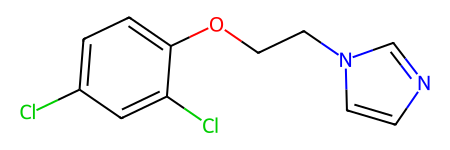

In [23]:
m

### 1.4 Molecular descriptors

Generally speaking molecular properties are descriptors to identify molecules, and since those descriptors are numbers, they could be used for machine learning purposes. Unfortunately, many descriptors are unique and could lead to misrepresentations and be impossible to learn. Alternatively, we could use a combination of descriptors to create unique arrays to identify molecules.

RDKIT provides a number of routines to compute descriptors ([see rdkit.Chem.Descriptors](https://www.rdkit.org/docs/source/rdkit.Chem.Descriptors.html)). The follow is an example to compute the molecular weight of a molecule.

In [7]:

import rdkit.Chem.Descriptors as Descriptor
smi = 'Clc1ccc(c(c1)Cl)OCCn1cncc1'      #Define molecule
smi= canon_smiles(smi)                 #Canonize molecule
m = smi2mol(smi)                        # Create RDKIT mol object

Descriptor.MolWt(m)  #molecular weight of the molecule

257.11999999999995

For this project we could use descritors defined in the following list:

In [8]:
getonly=['NHOHCount', 'NOCount', 'NumAliphaticCarbocycles',
                           'NumAliphaticHeterocycles', 'NumAliphaticRings',
                           'NumAromaticCarbocycles', 'NumAromaticHeterocycles',
                           'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 
                           'NumHeteroatoms', 'NumRadicalElectrons', 'NumRotatableBonds',
                           'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 
                           'NumSaturatedRings', 'NumValenceElectrons',
                            ]

## 1.4 Open Database

The description of the organic dyes database for solar cells can be found [here](https://github.com/alvarovm/solarcelldata/wiki/Dye-DB). Our database is expresed a CSV file (spread sheet). The rows are molecules, and the columns have experimental and simulated properties. The molecules are described as SMILE string format. The properties include the wavelenght `lamnda` in *nm* units computed with the methods sTDA, ZINDO (z), Time depenent density functional theory (tddft), and experimental (exp); extinction coefficient (epsilon); orbital enegies (HOMO, LUMO) in atomic units; first excitation energy (*f1*); solvent; and dipole moment (Debyes/*D*).

In [10]:
df = pd.read_csv('../data/extended_db_Zindo_Nov_2019_V5.csv').fillna(value = 0)
print('Column names:') 
for k, item in enumerate(df.columns.tolist()):
    print(f'\t{k}.- {item}')
print('Table Shape: {}'.format(df.shape))

Column names:
	0.- inchikey
	1.- smi_pre
	2.- smi_post
	3.- lambda_sTDA (nm)
	4.- f1_sTDA
	5.- lumo_dft
	6.- homo_dft
	7.- dmom_dft (D)
	8.- lambda_z (nm)
	9.- f1_z
	10.- lumo_z
	11.- homo_z
	12.- dmom_z (D)
	13.- lumo_mopac
	14.- homo_mopac
	15.- dmom_mopac (D)
	16.- lambda_tddft (nm)
	17.- f1_tddft
	18.- lambda_exp_max (nm)
	19.- epsilon_exp_max 
	20.- lambda_exp_min (nm)
	21.- epsilon_exp_min 
	22.- solvent
Table Shape: (9879, 23)


In [11]:
df.count()

inchikey               9879
smi_pre                9879
smi_post               9879
lambda_sTDA (nm)       9879
f1_sTDA                9879
lumo_dft               9879
homo_dft               9879
dmom_dft (D)           9879
lambda_z (nm)          9879
f1_z                   9879
lumo_z                 9879
homo_z                 9879
dmom_z (D)             9879
lumo_mopac             9879
homo_mopac             9879
dmom_mopac (D)         9879
lambda_tddft (nm)      9879
f1_tddft               9879
lambda_exp_max (nm)    9879
epsilon_exp_max        9879
lambda_exp_min (nm)    9879
epsilon_exp_min        9879
solvent                9879
dtype: int64

Notice that there are two SMILES: `smile_pre` and `smile_post`. The `smile_pre` are the SMILES generated directly from the molecules found in the literature, and `smiles_post` are a reduced version with only the active region of the molecule. Therefore  `smile_pre` are larger strings than the `smile_post`.

### 1.5 Exercises

Try to complete the following tasks. You can copy/paste some pieces of code from the materials compiled [in this wiki](https://github.com/alvarovm/solarcelldata/wiki/Working-with-Data).



* Remove systems without sTDA (disabled)

In [12]:
df['nostda']=df['lambda_sTDA (nm)'].apply(np.isnan) #create a column that has True or False, depending on sTDA are NaN
df = df[df.nostda == False]  #Filter all those that is has sTDA different than NaN

#df = df.dropna()

* Keep only the rows with `lambda_sTDA (nm)` that are bigger than zero.


In [13]:
df = df[df['lambda_sTDA (nm)'] >0 ]  #Filter those that are bigger than Zero
df.shape   #Print the final size

(7177, 24)

* Apply the function `HardValidSMI` to the columns with SMILES. How many cells have `True` and `False` ?


In [14]:
#example, Create a new column B with the results of applying foo(A)
#df['B'] = df['A'].apply(foo) 
df["valid_smi"] = df['smi_post'].apply(HardValidSMI)
df = df[df['valid_smi'] == True]
df.shape

(5660, 25)

* Create a `smiles` column with cannonized SMILES using the `canon_smiles` function.


In [15]:
df['cannon_smiles'] = df['smi_pre'].apply(canon_smiles)

* Create column with a RDKIT `molecule` object using the SMILES.


In [16]:
# Create a new column "mol" containing RDKit Mol objects
df["mol"] = df["cannon_smiles"].apply(smi2mol)
df.shape

(5660, 27)

* Create column with the Morgan fingerprint using the `applyMorganFP` to create a 2048 bit vectors using fragments up to radii 6, for example: `fp= applyMorganFP(mol,fptype='bit',fp_args={'radius':6, 'nBits':2048})`

In [17]:
df["morgan_fp_array"] = df["mol"].apply(lambda m: applyMorganFP(m, fp_type='bit', fp_args={'radius': 6, 'nBits': 2048}))

* Compute a set of descriptors (see list below) and add them as extra columns to the Dataframe


In [18]:
from rdkit.Chem import Descriptors


# Create a small lookup dict
desc_lookup = dict(Descriptors._descList)

for name in getonly:
    df[name] = df['mol'].apply(desc_lookup[name])


df.shape

(5660, 45)

* Compute the energy LUMO-HOMO gap from `mopac`, `zindo` and `dft`, compare them.


In [19]:
df["lumo_mopac"].apply(float)

1      -0.911
3      -0.751
6       0.018
7      -1.049
8      -1.727
        ...  
9874   -0.916
9875   -1.299
9876   -0.930
9877   -0.843
9878   -0.647
Name: lumo_mopac, Length: 5660, dtype: float64

In [20]:
cols = ["lumo_mopac", "homo_mopac", "lumo_z", "lumo_dft", "homo_z", "homo_dft"]
#df = df.dropna(subset=[cols])
#convert all to numeric
for col in cols:
    df[col] = df[col].apply(float)
        

#now compute gaps
df["gap_mopac"] = df["lumo_mopac"] - df["homo_mopac"]
df["gap_zindo"] = df["lumo_z"]     - df["homo_z"]
df["gap_dft"]   = df["lumo_dft"]   - df["homo_dft"]

#quickly comparing the gaps
print(df[["gap_mopac", "gap_zindo", "gap_dft"]].describe())


         gap_mopac    gap_zindo      gap_dft
count  5660.000000  5615.000000  5660.000000
mean      7.686559     7.160840     7.948144
std       0.784085     0.905837     1.095278
min       5.032000     4.235600     4.011900
25%       7.148000     6.544800     7.174975
50%       7.626000     7.085700     7.875300
75%       8.165000     7.710700     8.628650
max      10.354000    10.222100    11.534500


* Save the `Dataframe` as a pickle file.

In [21]:
df.to_pickle("my_dataframe.pkl")

###  1.6 Descritors list

The following script will compute a group of molecular descriptors to a column of RDKIT molecule object 'mol'. Make sure `df['mol']` exist.

In [22]:
import inspect
import rdkit.Chem.Descriptors as Descriptors

from collections import OrderedDict

getonly=['NHOHCount', 'NOCount', 'NumAliphaticCarbocycles',
                           'NumAliphaticHeterocycles', 'NumAliphaticRings',
                           'NumAromaticCarbocycles', 'NumAromaticHeterocycles',
                           'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 
                           'NumHeteroatoms', 'NumRadicalElectrons', 'NumRotatableBonds',
                           'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 
                           'NumSaturatedRings', 'NumValenceElectrons',
                            ]

calc_props = OrderedDict(inspect.getmembers(Descriptors, inspect.isfunction))
for key in list(calc_props.keys()):
    if key.startswith('_'):
        del calc_props[key]
    else:
        thisnot=False
        for myprop in getonly:
            if myprop == key:
                thisnot=True
        if not thisnot:
            del calc_props[key]
            
from tqdm import tqdm
def calc_all(dfc,calc_props,smiles_col='smiles'):
    for key,val in tqdm (calc_props.items()):
        dfc[key] = dfc['mol'].apply(val)
    return dfc
print('Found {} molecular descriptors in RDKIT'.format(len(calc_props)))
#calc_props
#df=calc_all(df,calc_props)

Found 17 molecular descriptors in RDKIT
